In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from pathlib import Path
from sklearn.metrics import cohen_kappa_score, f1_score
import matplotlib.colors as mcolors

# 1. Evaluation on controlled dataset

In [2]:
#annot_fever_dplaceq = "../../data/ablations/discrepancies/results/v1/FEVER-DPLACE-Q_v2_discp.csv"

annot_fever_dplaceq = "../../data/ablations/discrepancies/results/v2/FEVER-DPLACE-Q_v3_discp.csv"

In [3]:
df = pd.read_csv(annot_fever_dplaceq)
#df = df[df.label!="NOT_ENOUGH_INFO"]

models = ["qwen:32b", "llama3.3:70b", "gpt-4o-2024-08-06"]
f1_results = []

for model in models:
    per_class_f1 = []
    
    for label in df["label"].unique():
        # Create binary labels (1 if this label, 0 otherwise)
        true_binary = (df["label"] == label).astype(int)
        pred_binary = (df[f"discp_{model}"] == label).astype(int)

        # Compute F1-score for this specific label
        f1 = f1_score(true_binary, pred_binary, average="binary")
        per_class_f1.append(f1)

        # Store per-class F1-score
        f1_results.append({"Label": label, "Model": model, "F1-score": f1})

    # Compute Weighted-F1 for the model
    weighted_f1 = f1_score(df["label"], df[f"discp_{model}"], average="weighted")
    f1_results.append({"Label": "Weighted-F1", "Model": model, "F1-score": weighted_f1})

# Convert results to DataFrame
f1_df = pd.DataFrame(f1_results)

# Sort models correctly
model_order = models
f1_df["Model"] = pd.Categorical(f1_df["Model"], categories=model_order, ordered=True)

# Pivot for LaTeX output
latex_table = f1_df.pivot(index="Label", columns="Model", values="F1-score")
latex_table = latex_table[model_order]  # Ensure correct column order

# Convert to LaTeX table
latex_output = latex_table.to_latex(float_format="%.3f", caption="F1-score per Label and Weighted-F1", label="tab:f1_scores")
print(latex_output)

latex_table

\begin{table}
\caption{F1-score per Label and Weighted-F1}
\label{tab:f1_scores}
\begin{tabular}{lrrr}
\toprule
Model & qwen:32b & llama3.3:70b & gpt-4o-2024-08-06 \\
Label &  &  &  \\
\midrule
CONTRADICTION & 0.935 & 0.883 & 0.962 \\
CULTURAL_DISCREPANCY & 0.889 & 0.809 & 0.869 \\
NOT_ENOUGH_INFO & 0.825 & 0.889 & 0.889 \\
NO_DISCREPANCY & 0.980 & 0.961 & 0.942 \\
Weighted-F1 & 0.914 & 0.885 & 0.918 \\
\bottomrule
\end{tabular}
\end{table}



Model,qwen:32b,llama3.3:70b,gpt-4o-2024-08-06
Label,,,
CONTRADICTION,0.934579,0.882883,0.961538
CULTURAL_DISCREPANCY,0.888889,0.808511,0.868687
NOT_ENOUGH_INFO,0.825397,0.888889,0.888889
NO_DISCREPANCY,0.980000,0.960784,0.942308
Weighted-F1,0.913850,0.884973,0.917501


/tmp/ipykernel_642271/112770610.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


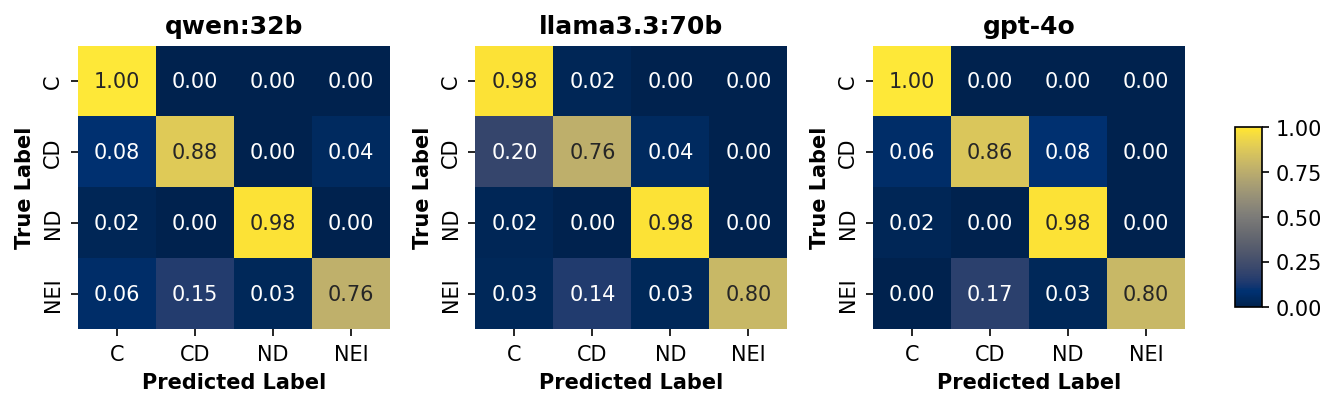

In [4]:
true_col = "label"
pred_cols = OrderedDict([
    ("qwen:32b", "discp_qwen:32b"),
    ("llama3.3:70b", "discp_llama3.3:70b"),
    ("gpt-4o-2024-08-06", "discp_gpt-4o-2024-08-06"),
])

# fixed order and pretty tick labels
order = ["CONTRADICTION", "CULTURAL_DISCREPANCY", "NO_DISCREPANCY", "NOT_ENOUGH_INFO"]
abbr = {"CONTRADICTION": "C", "CULTURAL_DISCREPANCY": "CD", "NO_DISCREPANCY": "ND", "NOT_ENOUGH_INFO": "NEI"}
true_labels = [abbr[x] for x in order]
pred_labels = true_labels  # same order for columns

def row_norm_confusion(y_true, y_pred, labels):
    ct = pd.crosstab(
        pd.Categorical(y_true, categories=labels),
        pd.Categorical(y_pred, categories=labels),
        dropna=False
    ).astype(float)
    row_sums = ct.sum(axis=1).replace(0, np.nan)
    m = (ct.T / row_sums).T.fillna(0.0)
    # return as DataFrame with pretty tick labels to pass to seaborn
    m.index = [abbr[i] for i in m.index]
    m.columns = [abbr[j] for j in m.columns]
    return m

# compute matrices for each model
models = OrderedDict()
for title, col in pred_cols.items():
    models[title] = row_norm_confusion(df[true_col], df[col], order)

# --- Plotting (your styling) ---
fig, axes = plt.subplots(1, 3, figsize=(9, 3), dpi=150)
vmin, vmax = 0.0, 1.0
cmap = "cividis"  # Updated color palette

for ax, (title, matrix) in zip(axes, models.items()):
    sns.heatmap(
        matrix, annot=True, fmt=".2f", cmap=cmap, vmin=vmin, vmax=vmax,
        xticklabels=pred_labels, yticklabels=true_labels, ax=ax, cbar=False
    )
    title = title if title != "gpt-4o-2024-08-06" else "gpt-4o"
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel("Predicted Label", fontsize=10, fontweight='bold')
    ax.set_ylabel("True Label", fontsize=10, fontweight='bold')

# shared colorbar
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(bottom=0.25)


# optional: save
plt.savefig("../../figures/confusion_fever_d_place_q_fixed.pdf", bbox_inches="tight")

plt.show()


# 2. Evaluation on controlled + ROSIE samples by humans

In [5]:
path_original = Path("../../data/ablations/discrepancies/eval_tasks/discrepancies_v5.xlsx")
df = pd.read_excel(path_original)

In [6]:
pivot = (
    df.groupby(["source", "model", "discrepancy"])
      .size()
      .unstack(fill_value=0)   # discrepancy values become columns
      .reset_index()
)

pivot


discrepancy,source,model,CONTRADICTION,CULTURAL_DISCREPANCY,NOT_ENOUGH_INFO,NO_DISCREPANCY
0,11,gpt-4o,0,0,10,10
1,11,llama3.3:70b,10,3,10,10
2,11,qwen:32b,8,4,10,10
3,15,gpt-4o,0,0,10,10
4,15,llama3.3:70b,13,6,10,10
5,15,qwen:32b,10,6,10,10
6,FEVER-DPLACE-Q,synthetic,50,50,35,50


In [7]:
"""
df_aux = df[df.model!="synthetic"]

subset = df_aux.loc[df_aux.discrepancy == 'CULTURAL_DISCREPANCY',
                    ['question', 'answer_s', 'answer_t']]

for _, row in subset.iterrows():
    print(f"QUESTION: {row['question']}")
    print(f"ANSWER_s: {row['answer_s']}")
    print(f"ANSWER_t: {row['answer_t']}")
    print("\n-----")
"""

'\ndf_aux = df[df.model!="synthetic"]\n\nsubset = df_aux.loc[df_aux.discrepancy == \'CULTURAL_DISCREPANCY\',\n                    [\'question\', \'answer_s\', \'answer_t\']]\n\nfor _, row in subset.iterrows():\n    print(f"QUESTION: {row[\'question\']}")\n    print(f"ANSWER_s: {row[\'answer_s\']}")\n    print(f"ANSWER_t: {row[\'answer_t\']}")\n    print("\n-----")\n'

In [8]:
path_task = Path("../../data/ablations/discrepancies/results/v2")
path_ann1 = path_task / "discrepancies_v5_ann_a.xlsx"
path_ann2 = path_task / "discrepancies_v5_ann_d.xlsx"
path_ann3 = path_task / "discrepancies_v5_ann24.xlsx"
#25 could be but dis to high

In [9]:
# this can vary depending on the annotator (they sometimes don't follow instructions)
df_ann=pd.read_excel(path_ann1)
print(df_ann.label.unique())
print(f"number of CONTRADICTION: {len(df_ann[df_ann.label == 'CONTRADICTION'])/len(df_ann)}")
print(f"number of NO_DISCREPANCY: {len(df_ann[df_ann.label == 'NO_DISCREPANCY'])/len(df_ann)}")
print(f"number of CULTURAL_DISCREPANCY: {len(df_ann[df_ann.label == 'CULTURAL_DISCREPANCY'])/len(df_ann)}")

['CULTURAL_DISCREPANCY' 'NO_DISCREPANCY' 'CONTRADICTION' 'NOT_ENOUGH_INFO']
number of CONTRADICTION: 0.2410958904109589
number of NO_DISCREPANCY: 0.3561643835616438
number of CULTURAL_DISCREPANCY: 0.14246575342465753


In [10]:
df_ann2 = pd.read_excel(path_ann2)
df_ann2["label2"] = df_ann2["label"]
print(df_ann2.label.unique())
print(f"number of CONTRADICTION: {len(df_ann2[df_ann2.label2 == 'CONTRADICTION'])/len(df_ann2)}")
print(f"number of NO_DISCREPANCY: {len(df_ann2[df_ann2.label2 == 'NO_DISCREPANCY'])/len(df_ann2)}")
print(f"number of CULTURAL_DISCREPANCY: {len(df_ann2[df_ann2.label2 == 'CULTURAL_DISCREPANCY'])/len(df_ann2)}")

['CULTURAL_DISCREPANCY' 'NO_DISCREPANCY' 'NOT_ENOUGH_INFO' 'CONTRADICTION']
number of CONTRADICTION: 0.1917808219178082
number of NO_DISCREPANCY: 0.3506849315068493
number of CULTURAL_DISCREPANCY: 0.19452054794520549


In [11]:
df_ann3 = pd.read_excel(path_ann3)
df_ann3["label3"] = df_ann3["label"]
print(df_ann3.label.unique())
print(f"number of CONTRADICTION: {len(df_ann3[df_ann3.label3 == 'CONTRADICTION'])/len(df_ann3)}")
print(f"number of NO_DISCREPANCY: {len(df_ann3[df_ann3.label3 == 'NO_DISCREPANCY'])/len(df_ann3)}")
print(f"number of CULTURAL_DISCREPANCY: {len(df_ann3[df_ann3.label3 == 'CULTURAL_DISCREPANCY'])/len(df_ann3)}")

['CONTRADICTION' 'NO_DISCREPANCY' 'NOT_ENOUGH_INFO' 'CULTURAL_DISCREPANCY']
number of CONTRADICTION: 0.29863013698630136
number of NO_DISCREPANCY: 0.38082191780821917
number of CULTURAL_DISCREPANCY: 0.06027397260273973


In [12]:
df_ann = df_ann.merge(df_ann2[["id_discr", "label2"]], on="id_discr", how="left")
df_ann = df_ann.merge(df_ann3[["id_discr", "label3"]], on="id_discr", how="left")
df_ann

,id_discr,question,answer_t,answer_s,label,label2,label3
0,0,Is the initial marital residence typically est...,"Yes, it is often avunculocal, residing with or...","No, it is ambilocal, with residence optionally...",CULTURAL_DISCREPANCY,CULTURAL_DISCREPANCY,CONTRADICTION
1,1,Is the risk of serious complications from amni...,"YES, the risk of serious complications from am...","YES, the risk of serious complications from am...",NO_DISCREPANCY,NO_DISCREPANCY,NO_DISCREPANCY
2,2,Has placental vasoconstriction been observed i...,"YES, placental vasoconstriction has been obser...","YES, placental vasoconstriction has been obser...",NO_DISCREPANCY,NO_DISCREPANCY,NO_DISCREPANCY
3,3,Did Quentin Tarantino make a movie?,"Yes, Quentin Tarantino made a movie.","Yes, Quentin Tarantino made several movies, in...",NO_DISCREPANCY,NO_DISCREPANCY,NO_DISCREPANCY
4,4,Does erythroblastosis fetalis refer to a condi...,"YES, erythroblastosis fetalis refers to a cond...","NO, erythroblastosis fetalis specifically refe...",CONTRADICTION,CULTURAL_DISCREPANCY,CONTRADICTION
...,...,...,...,...,...,...,...
360,360,Should you contact your provider if you experi...,"YES, you should contact your provider if you e...","YES, you should contact your provider if you e...",NO_DISCREPANCY,NO_DISCREPANCY,NO_DISCREPANCY
361,361,Does neonatal respiratory distress syndrome (R...,"YES, neonatal respiratory distress syndrome (R...","YES, neonatal respiratory distress syndrome (R...",NO_DISCREPANCY,NO_DISCREPANCY,NO_DISCREPANCY
362,362,Has Emily Blunt yet to appear in a film adapte...,"Yes, Emily Blunt has yet to appear in a film a...","No, Emily Blunt appeared in ""Salmon Fishing in...",CONTRADICTION,CONTRADICTION,CONTRADICTION
363,363,Is animal husbandry typically performed by mal...,No data is available on this specialization.,"Yes, it is primarily performed by males, with ...",NOT_ENOUGH_INFO,NOT_ENOUGH_INFO,NOT_ENOUGH_INFO


In [13]:
df_ann.columns

Index(['id_discr', 'question', 'answer_t', 'answer_s', 'label', 'label2',
       'label3'],
      dtype='object')

In [14]:
# drop duplicates by question, answer_text
df_ann = df_ann.drop_duplicates(subset=["question", "answer_t"])

df_ann = df_ann.merge(df[["id_discr", "model", "discrepancy", "reason"]], on="id_discr", how="left")
df_ann["model"] = df_ann["model"].fillna("synthetic")
df_ann["model"] = df_ann["model"].apply(lambda x: x.replace('gpt-4o-2024-08-06', 'gpt-4o'))

df_ann["agree"] = df_ann["label"] == df_ann["discrepancy"]
df_ann["agree2"] = df_ann["label2"] == df_ann["discrepancy"]
df_ann["agree3"] = df_ann["label3"] == df_ann["discrepancy"]

keep_cols = [col for col in df_ann if not col.startswith("Unnamed")]
df_ann = df_ann[keep_cols]

df_summary = df_ann.groupby(["model", "discrepancy"]).agg(
    agree_count=("agree", "sum"),    
    agree2_count=("agree2", "sum"),  
    agree3_count=("agree3", "sum"),
    total=("agree", "count")
).reset_index()

df_summary["agree_ratio"] = df_summary["agree_count"] / df_summary["total"]
df_summary["agree2_ratio"] = df_summary["agree2_count"] / df_summary["total"]
df_summary["agree3_ratio"] = df_summary["agree3_count"] / df_summary["total"]


df_summary

,model,discrepancy,agree_count,agree2_count,agree3_count,total,agree_ratio,agree2_ratio,agree3_ratio
0,gpt-4o,NOT_ENOUGH_INFO,20,20,20,20,1.000000,1.000000,1.000000
1,gpt-4o,NO_DISCREPANCY,20,20,20,20,1.000000,1.000000,1.000000
2,llama3.3:70b,CONTRADICTION,22,16,12,23,0.956522,0.695652,0.521739
3,llama3.3:70b,CULTURAL_DISCREPANCY,0,2,0,9,0.000000,0.222222,0.000000
4,llama3.3:70b,NOT_ENOUGH_INFO,20,20,20,20,1.000000,1.000000,1.000000
5,llama3.3:70b,NO_DISCREPANCY,19,18,19,20,0.950000,0.900000,0.950000
6,qwen:32b,CONTRADICTION,10,11,10,17,0.588235,0.647059,0.588235
7,qwen:32b,CULTURAL_DISCREPANCY,0,0,1,10,0.000000,0.000000,0.100000
8,qwen:32b,NOT_ENOUGH_INFO,20,20,20,20,1.000000,1.000000,1.000000
9,qwen:32b,NO_DISCREPANCY,20,19,18,20,1.000000,0.950000,0.900000


## 2.1. Agreement

In [15]:
inter_annotator_kappa = cohen_kappa_score(df_ann["label"], df_ann["label2"])

print(f"Inter-annotator Cohen's Kappa: {inter_annotator_kappa:.3f}")

Inter-annotator Cohen's Kappa: 0.857


In [16]:
pairs = [("label","label2"), ("label","label3"), ("label2","label3")]

pair_kappas = {}
pair_ns = {}

for a, b in pairs:
    sub = df_ann[[a, b]].dropna()   # solo filas con ambas etiquetas presentes
    if sub.empty:
        continue
    k = cohen_kappa_score(sub[a], sub[b])
    pair_kappas[f"{a}-{b}"] = k
    pair_ns[f"{a}-{b}"] = len(sub)

# Promedio simple y (opcional) ponderado por nº de ítems válidos
macro = np.mean(list(pair_kappas.values()))
weighted = np.average(list(pair_kappas.values()), weights=list(pair_ns.values()))

print("Kappas pareadas:", pair_kappas)
print(f"Promedio (macro): {macro:.3f}")
print(f"Promedio ponderado: {weighted:.3f}")


Kappas pareadas: {'label-label2': 0.8574108818011257, 'label-label3': 0.7198848841989859, 'label2-label3': 0.6529165457485179}
Promedio (macro): 0.743
Promedio ponderado: 0.743


In [17]:
from statsmodels.stats.inter_rater import fleiss_kappa

def fleiss_kappa_from_labels(df, rater_cols):
    """
    df[rater_cols]: columnas con etiquetas nominales (p.ej., 4 clases).
    Filtra a filas completas (sin NaN) para que todos los ítems tengan el mismo nº de anotadores.
    Devuelve (kappa, n_items, classes).
    """
    sub = df[rater_cols].dropna(how="any").astype(str)
    if sub.empty:
        return np.nan, 0, []
    # Lista ordenada de clases observadas
    classes = sorted(pd.unique(sub.values.ravel()))
    cls_to_idx = {c: i for i, c in enumerate(classes)}

    # Matriz de conteos (n_items x n_classes)
    counts = np.zeros((len(sub), len(classes)), dtype=int)
    for i, row in enumerate(sub.itertuples(index=False)):
        for lab in row:                       # recorre los 3 votos
            counts[i, cls_to_idx[lab]] += 1   # suma en la clase correspondiente

    kappa = fleiss_kappa(counts)
    return float(kappa), len(sub), classes

kappa_fleiss, n_items, classes = fleiss_kappa_from_labels(df_ann, ["label","label2","label3"])
print(f"Fleiss' κ (3 anotadores, {n_items} ítems, clases={classes}): {kappa_fleiss:.3f}")

Fleiss' κ (3 anotadores, 364 ítems, clases=['CONTRADICTION', 'CULTURAL_DISCREPANCY', 'NOT_ENOUGH_INFO', 'NO_DISCREPANCY']): 0.743


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

agreement_results = []

for (model, category), group in df_ann.groupby(["model", "discrepancy"]):
    y_true1 = (group["label"]  == category).astype(int)
    y_true2 = (group["label2"] == category).astype(int)
    y_true3 = (group["label3"] == category).astype(int)
    y_pred  = (group["discrepancy"] == category).astype(int) 

    f1_label  = f1_score(y_true1, y_pred, zero_division=0)
    f1_label2 = f1_score(y_true2, y_pred, zero_division=0)
    f1_label3 = f1_score(y_true3, y_pred, zero_division=0)

    agreement_results.append({
        "model": model,
        "category": category,
        "f1_label": f1_label,
        "f1_label2": f1_label2,
        "f1_label3": f1_label3,
        "count": len(group)
    })

agreement_by_category_df = pd.DataFrame(agreement_results)
agreement_by_category_df

,model,category,f1_label,f1_label2,f1_label3,count
0,gpt-4o,NOT_ENOUGH_INFO,1.000000,1.000000,1.000000,20
1,gpt-4o,NO_DISCREPANCY,1.000000,1.000000,1.000000,20
2,llama3.3:70b,CONTRADICTION,0.977778,0.820513,0.685714,23
3,llama3.3:70b,CULTURAL_DISCREPANCY,0.000000,0.363636,0.000000,9
4,llama3.3:70b,NOT_ENOUGH_INFO,1.000000,1.000000,1.000000,20
5,llama3.3:70b,NO_DISCREPANCY,0.974359,0.947368,0.974359,20
6,qwen:32b,CONTRADICTION,0.740741,0.785714,0.740741,17
7,qwen:32b,CULTURAL_DISCREPANCY,0.000000,0.000000,0.181818,10
8,qwen:32b,NOT_ENOUGH_INFO,1.000000,1.000000,1.000000,20
9,qwen:32b,NO_DISCREPANCY,1.000000,0.974359,0.947368,20


## 2.2. Discrepancy category figure

Agreement F1 is computed per predicted category as the binary F1 between the model’s predictions and each annotator’s gold labels, averaged across annotators.

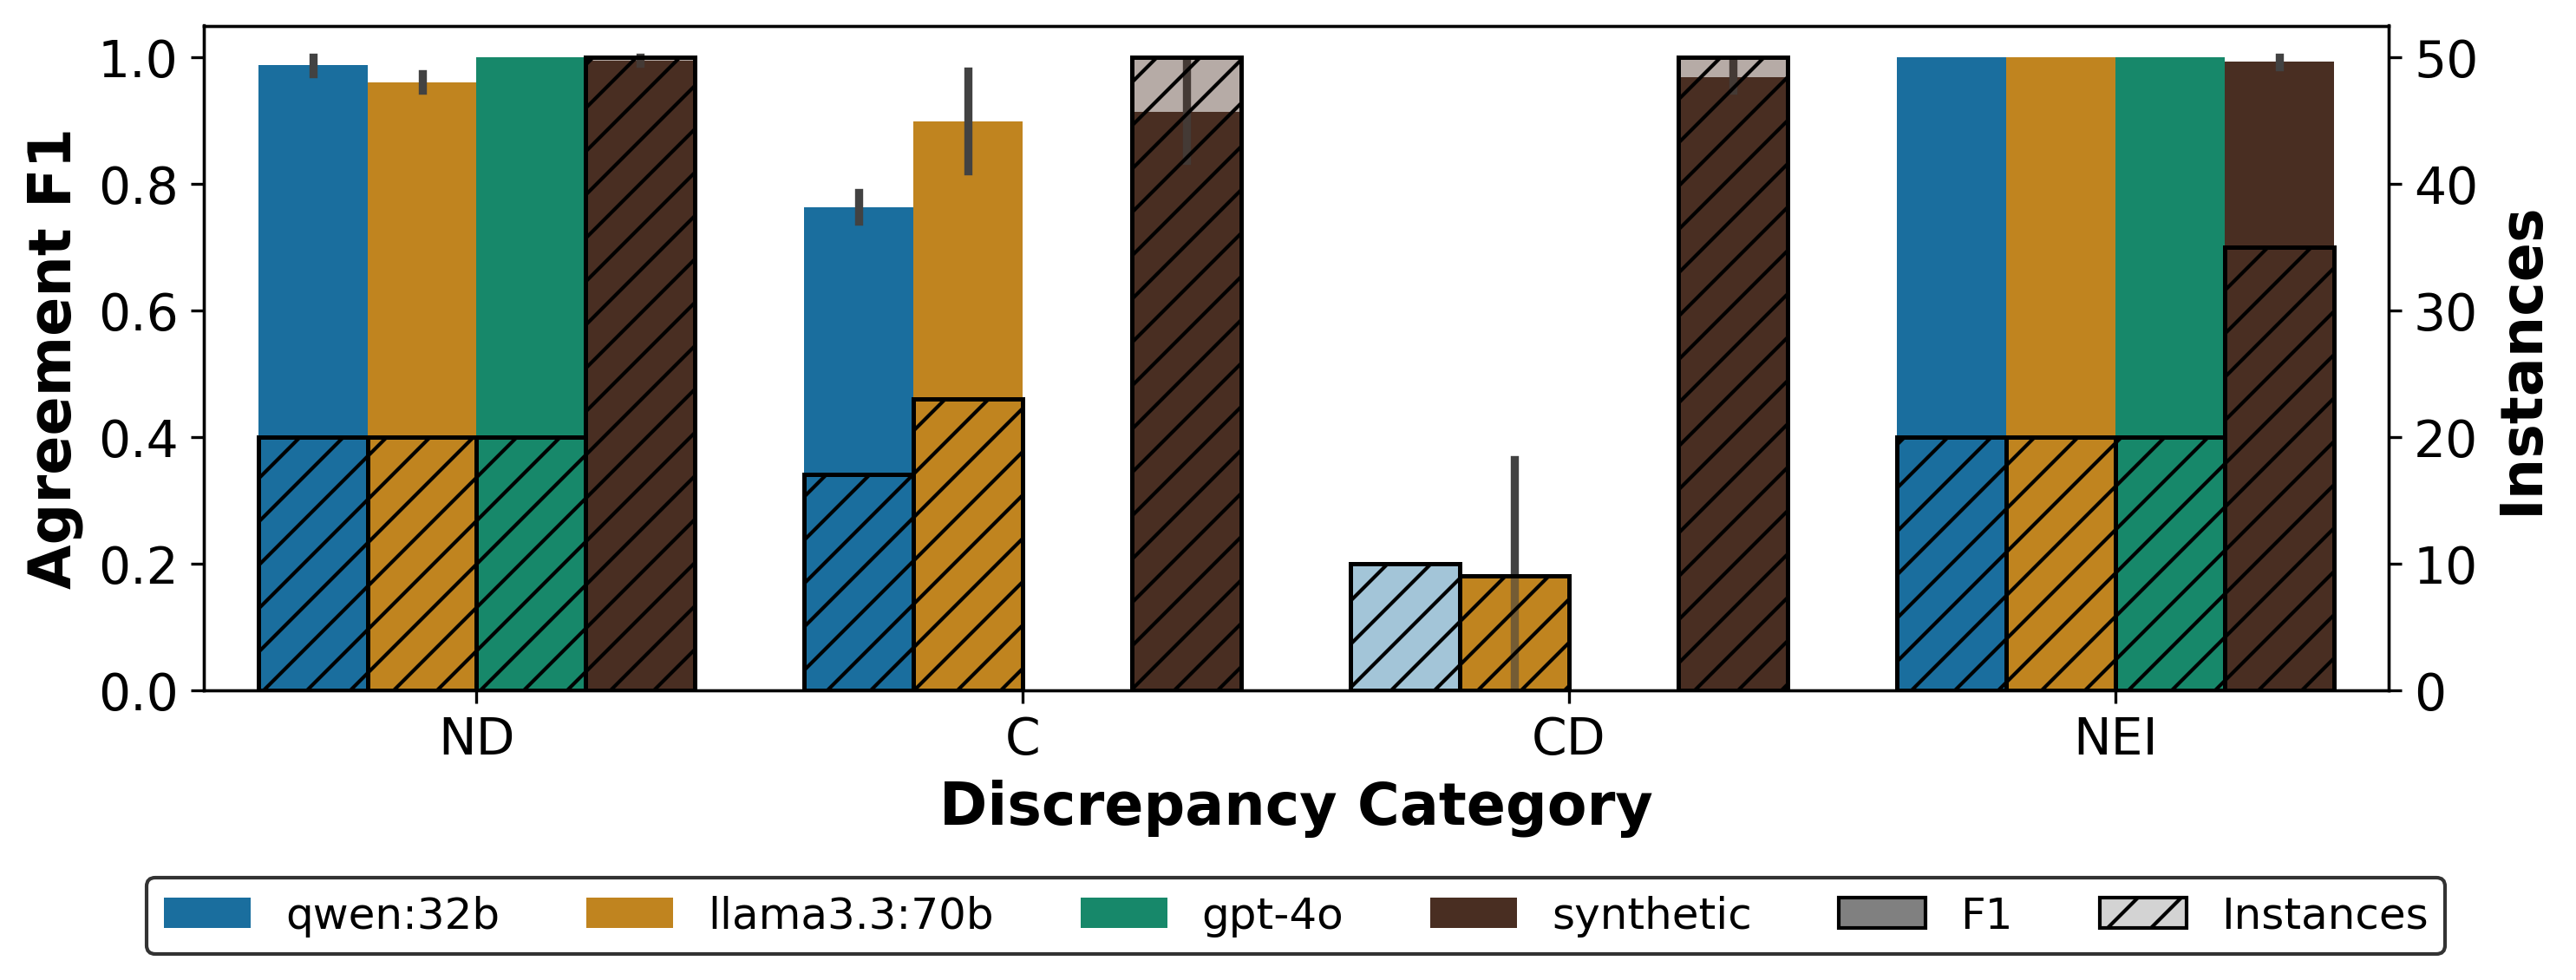

In [19]:
category_labels = {
    "NO_DISCREPANCY": "ND",
    "CONTRADICTION": "C",
    "CULTURAL_DISCREPANCY": "CD",
    "NOT_ENOUGH_INFO": "NEI"
}
agreement_by_category_df["category"] = (
    agreement_by_category_df["category"].replace(category_labels)
)

cat_order = ["ND", "C", "CD", "NEI"]
agreement_by_category_df["category"] = pd.Categorical(
    agreement_by_category_df["category"],
    categories=cat_order,
    ordered=True
)

desired_model_order = [
    "qwen:32b", "llama3.3:70b", "gpt-4o", "synthetic" 
]
model_color_map = {
    "qwen:32b": "#0474b4",  
    "llama3.3:70b": "#db8b04",  
    "gpt-4o": "#049b73", 
    "synthetic": "#4f2c1c",  
}
present_models = agreement_by_category_df["model"].dropna().unique().tolist()
full_model_order = (
    [m for m in desired_model_order if m in present_models] +
    [m for m in present_models if m not in desired_model_order]
)

agreement_by_category_df["model"] = pd.Categorical(
    agreement_by_category_df["model"],
    categories=full_model_order,
    ordered=True
)

fallback_cycle = sns.color_palette("tab10", n_colors=max(10, len(full_model_order)))
fallback_map = {m: fallback_cycle[i % len(fallback_cycle)] for i, m in enumerate(full_model_order)}

palette_map = {
    m: mcolors.to_rgba(model_color_map[m]) if m in model_color_map else fallback_map[m]
    for m in full_model_order
}

f1_melted = agreement_by_category_df.melt(
    id_vars=["model", "category", "count"], 
    value_vars=["f1_label", "f1_label2"],   
    var_name="metric", value_name="value"
)

plt.figure(figsize=(10, 4), dpi=300)

# F1 (solid bars)
ax = sns.barplot(
    data=f1_melted,
    x="category", y="value", hue="model",
    palette=palette_map, hue_order=full_model_order,
    dodge=True, order=cat_order
)

plt.xlabel("Discrepancy Category", fontsize=16, fontweight="bold")
plt.ylabel("Agreement F1", fontsize=16, fontweight="bold")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Secondary axis: counts (hatched bars)
ax2 = ax.twinx()
bars2 = sns.barplot(
    data=agreement_by_category_df,
    x="category", y="count", hue="model",
    palette=palette_map, hue_order=full_model_order,
    dodge=True, ax=ax2, order=cat_order
)

for bar in bars2.patches:
    base = bar.get_facecolor()
    lighter = mcolors.to_rgba(base, alpha=0.4)
    bar.set_facecolor(lighter)
    bar.set_hatch("//")
    bar.set_edgecolor("black")
    bar.set_linewidth(1.2)

ax2.set_ylabel("Instances", fontsize=16, fontweight="bold")
ax2.tick_params(axis="y", labelsize=14)

ax.get_legend().remove()
ax2.get_legend().remove()

from matplotlib.patches import Patch
custom = [
    Patch(facecolor="gray", edgecolor="black", label="F1"),
    Patch(facecolor="lightgray", edgecolor="black", hatch="//", label="Instances")
]

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles + custom, labels + ["F1", "Instances"],
          loc="upper center", bbox_to_anchor=(0.5, -0.25),
          ncol=len(full_model_order)+2, frameon=True, fontsize=12).get_frame().set_edgecolor("black")

plt.tight_layout()
plt.savefig("../../figures/mind_ablation_discrepancy_evaluation.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


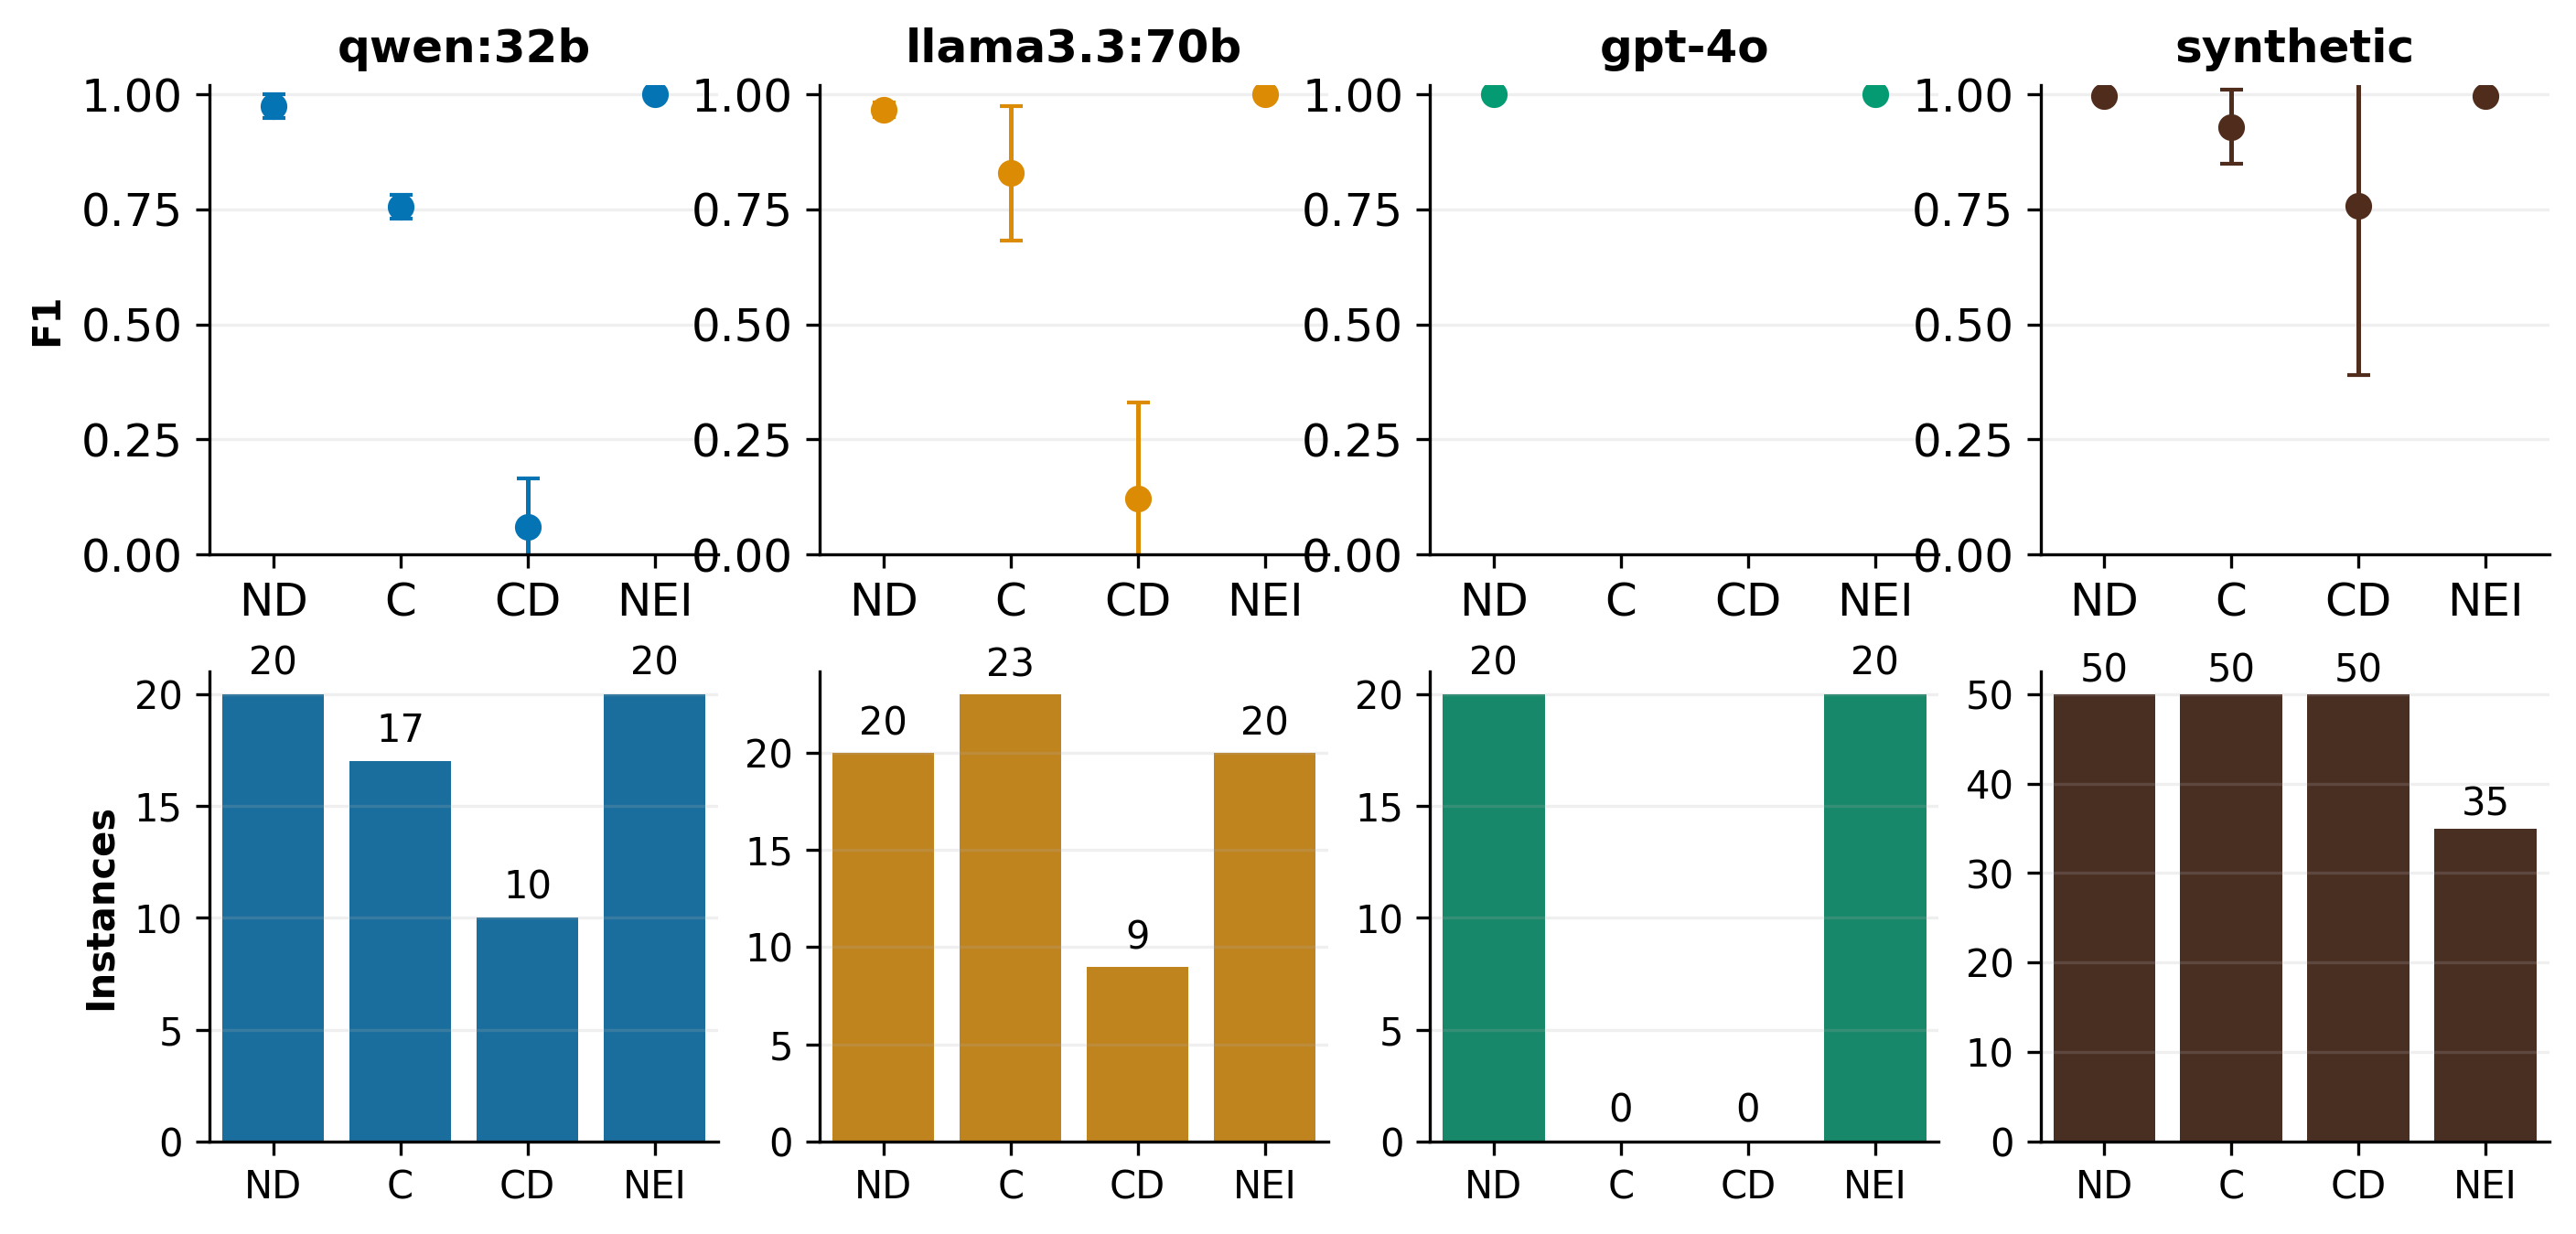

In [20]:
# Base font sizes (top row larger, bottom row smaller)
top_title_size = 16
top_label_size = 14
top_tick_size  = 12

bot_label_size = 12
bot_tick_size  = 10
bot_text_size  = 10   # for bar annotations

f1_melted = agreement_by_category_df.melt(
    id_vars=["model", "category", "count"],
    value_vars=["f1_label", "f1_label2", "f1_label3"],
    var_name="metric", value_name="value"
)

fig = plt.figure(figsize=(11,5), dpi=300)
gs = fig.add_gridspec(nrows=2, ncols=len(full_model_order),
                      height_ratios=[1,1], hspace=0.25, wspace=0.2)

for j, m in enumerate(full_model_order):
    ax_top = fig.add_subplot(gs[0, j])
    ax_bot = fig.add_subplot(gs[1, j], sharex=ax_top)

    # --- Top row (F1 scatter + errorbars) ---
    dfm_pts = f1_melted.query("model == @m")
    agg = (dfm_pts.groupby("category", observed=False)["value"]
           .agg(mean="mean", sd=lambda s: s.std(ddof=1))
           .reindex(cat_order))

    x = np.arange(len(cat_order))
    y = agg["mean"].to_numpy()
    yerr = agg["sd"].fillna(0).to_numpy()

    ax_top.scatter(x, y, s=36, color=palette_map[m], zorder=3)
    ax_top.errorbar(x, y, yerr=yerr, fmt="none", ecolor=palette_map[m],
                    elinewidth=1.2, capsize=3, zorder=2)
    ax_top.set_xticks(x, cat_order)
    ax_top.set(
        ylim=(0, 1.02),
        ylabel="F1" if j==0 else "",
        title=m
    )
    ax_top.set_title(m, fontweight="bold")
    ax_top.set_ylabel("F1" if j == 0 else "", fontweight="bold")

    ax_top.tick_params(axis="x", labelsize=top_tick_size)
    ax_top.tick_params(axis="y", labelsize=top_tick_size)
    ax_top.grid(axis="y", alpha=.2)

    # --- Bottom row (Counts barplot) ---
    dfm_counts = (
        agreement_by_category_df.query("model == @m")
        .set_index("category")
        .reindex(cat_order)            
        .reset_index()
        .fillna({"count": 0})         
    )

    sns.barplot(data=dfm_counts, x="category", y="count",
                order=cat_order, ax=ax_bot,
                color=mcolors.to_rgba(palette_map[m], alpha=.55))

    for p, n in zip(ax_bot.patches, dfm_counts["count"].tolist()):
        ax_bot.text(
            p.get_x()+p.get_width()/2,
            p.get_height()+0.5,
            int(n),
            ha="center", va="bottom",
            fontsize=bot_text_size
        )

    ax_bot.set_ylabel("Instances" if j == 0 else "", fontweight="bold")
    ax_bot.set_xlabel("", fontweight="bold")  # if you later set xlabel text
    ax_bot.tick_params(axis="x", labelsize=bot_tick_size)
    ax_bot.tick_params(axis="y", labelsize=bot_tick_size)
    ax_bot.grid(axis="y", alpha=.2)

for ax in fig.axes:
    sns.despine(ax=ax)


plt.savefig("../../figures/mind_ablation_discrepancy_evaluation_counts.pdf", format="pdf", bbox_inches="tight")
plt.show()


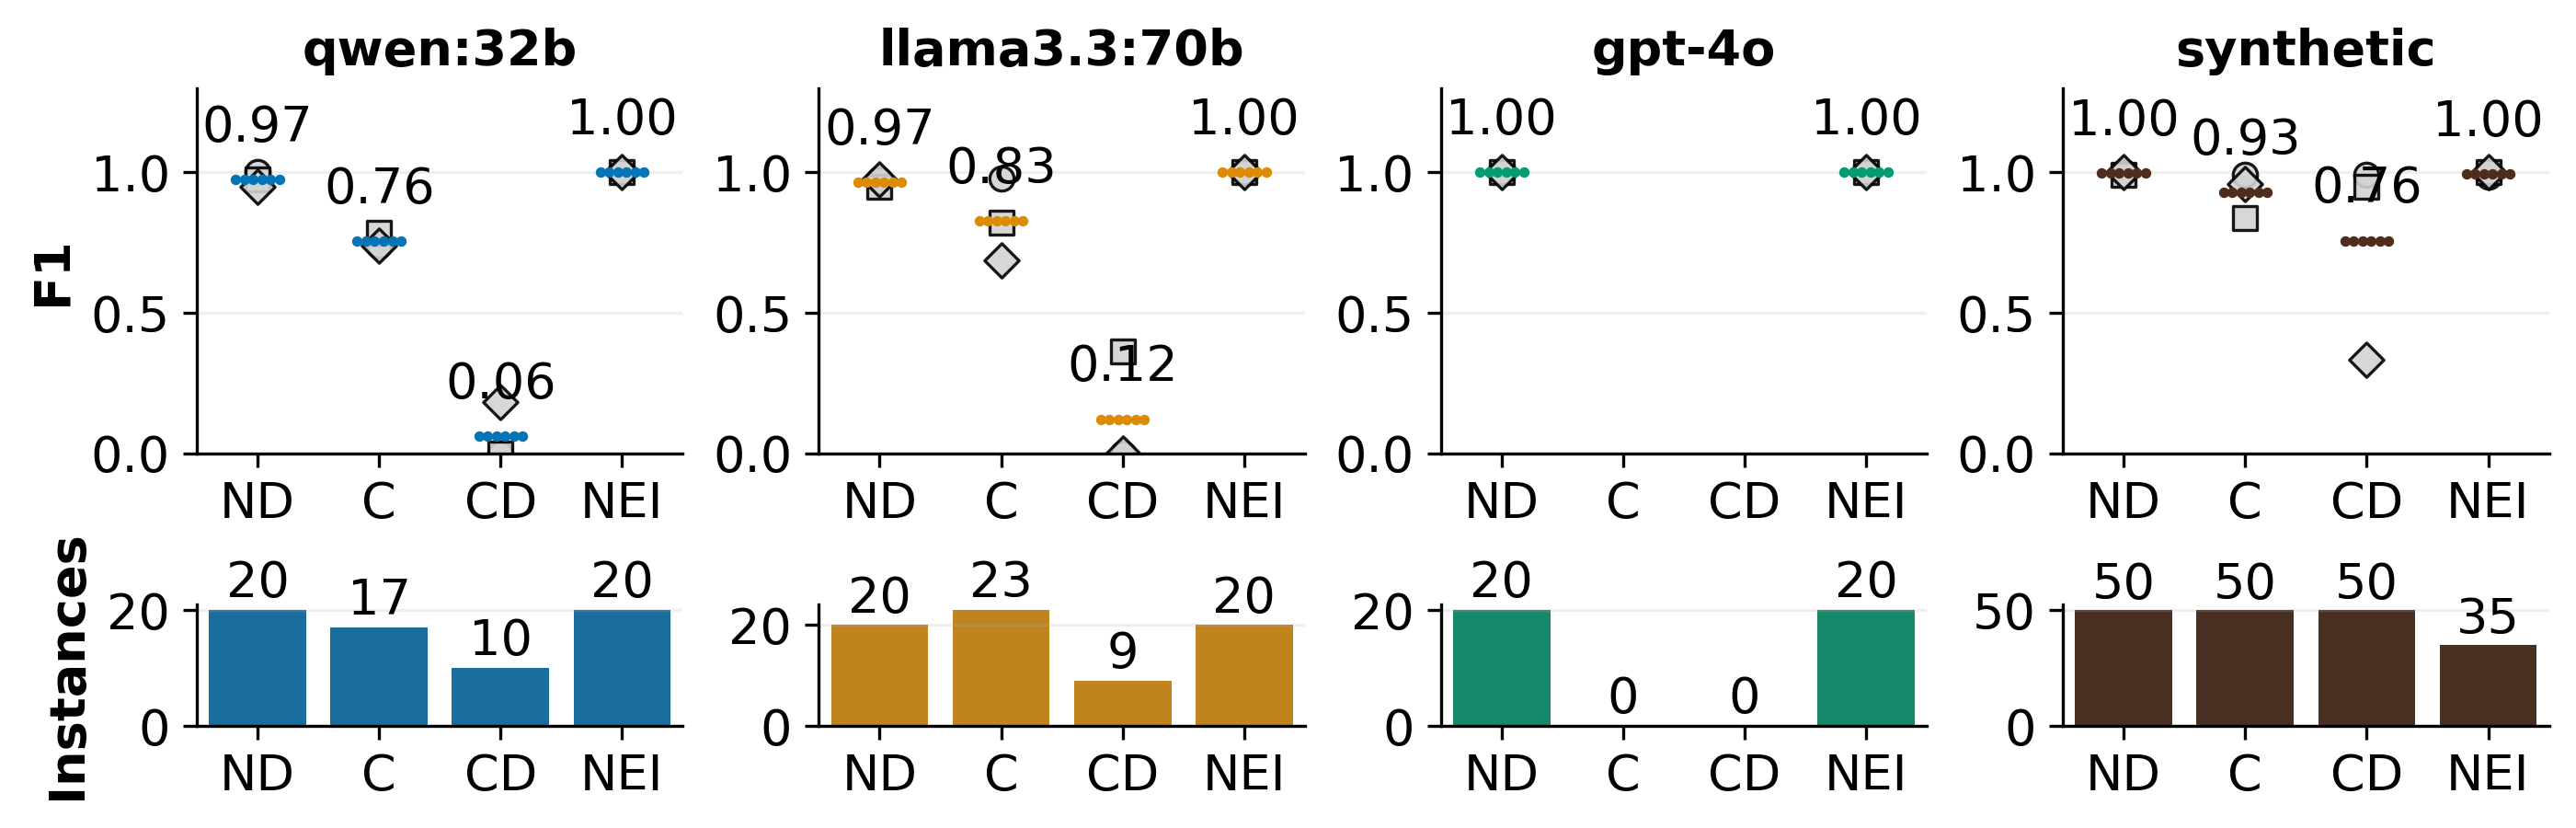

In [21]:

import matplotlib as mpl

# --- make fonts bigger globally ---
mpl.rcParams.update({
    "font.size": 13,
    "axes.titlesize": 13,
    "axes.labelsize": 13,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
})

def near_mean_text_y(mu, other_ys, ylim,
                     min_gap=0.03,     # min clearance from any dot/mean
                     edge_pad=0.02,    # distance from axis edge
                     label_offset=0.02 # extra nudge so text doesn't kiss the dots
                     ):
    lo, hi = ylim
    closest = min(abs(mu - y) for y in ([mu] + list(other_ys)))
    gap = max(min_gap, closest + 0.01)

    y_above = mu + gap + label_offset
    if y_above <= hi - edge_pad:
        return y_above, "bottom"

    y_below = mu - gap - label_offset
    y_below = max(y_below, lo + edge_pad)
    return y_below, "top"


fig = plt.figure(figsize=(11, 3), dpi=300)
gs = fig.add_gridspec(
    nrows=2, ncols=len(full_model_order),
    height_ratios=[3, 1], hspace=0.62, wspace=0.28
)

annotator_cols = ["f1_label", "f1_label2", "f1_label3"]
markers = ["o", "s", "D"]  # circle, square, diamond

# --- prepare for legend handles ---
legend_handles, legend_labels = None, None

# -------- plotting loop --------
for j, m in enumerate(full_model_order):
    ax_top = fig.add_subplot(gs[0, j])
    ax_bot = fig.add_subplot(gs[1, j], sharex=ax_top)

    dfm = (agreement_by_category_df
           .query("model == @m")
           .set_index("category")
           .reindex(cat_order))

    x = np.arange(len(cat_order))

    # annotator dots
    for col, marker in zip(annotator_cols, markers):
        ax_top.scatter(
            x, dfm[col],
            s=40, alpha=0.9,
            facecolor="lightgray", edgecolor="black",
            marker=marker, linewidth=0.8, zorder=2,
            label=col if j == 0 else None
        )

    # mean per category
    dfm["f1_mean"] = dfm[annotator_cols].mean(axis=1)
    mean_color = palette_map[m]

    # ---- dynamic ylim: make headroom based on actual points ----
    ymax_points = max(dfm[annotator_cols].max().max(), dfm["f1_mean"].max())
    yhi = min(1.30, max(1.0, ymax_points + 0.3))
    ylim = (0.0, yhi)
    ax_top.set_ylim(*ylim)

    # draw means + labels
    for xi, (row_idx, row) in zip(x, dfm.iterrows()):
        mu = row["f1_mean"]
        offsets = np.linspace(-0.18, 0.18, 6)
        ax_top.scatter(
            xi + offsets, [mu]*len(offsets),
            s=12, color=mean_color, marker=".", zorder=3,
            label="mean" if (j==0 and xi==0) else None
        )

        other_ys = [row[c] for c in annotator_cols if pd.notna(row[c])]
        y_txt, va = near_mean_text_y(
            mu, other_ys, ylim=ylim,
            min_gap=0.03, edge_pad=0.02,
            label_offset=0.07
        )

        ax_top.text(
            xi, y_txt, f"{mu:.2f}",
            ha="center", va=va, fontsize=13,
            color="black", zorder=4, clip_on=True
        )

    ax_top.set_title(m, fontweight="bold")
    ax_top.set_xticks(x, cat_order)
    ax_top.set_ylabel("F1" if j == 0 else "", fontweight="bold")
    ax_top.grid(axis="y", alpha=.2)

    # --- counts (smaller panel) ---
    dfm_counts = dfm.reset_index().fillna({"count": 0})
    sns.barplot(
        data=dfm_counts, x="category", y="count",
        order=cat_order, ax=ax_bot,
        color=mcolors.to_rgba(mean_color, alpha=.55)
    )
    for p, n in zip(ax_bot.patches, dfm_counts["count"].tolist()):
        ax_bot.text(p.get_x()+p.get_width()/2,
                    p.get_height()+0.5, int(n),
                    ha="center", va="bottom", fontsize=13)

    ax_bot.set_ylabel("Instances" if j == 0 else "", fontweight="bold")
    ax_bot.grid(axis="y", alpha=.2)

    # --- grab legend handles only once (from first subplot) ---
    if j == 0:
        legend_handles, legend_labels = ax_top.get_legend_handles_labels()

# tidy
for ax in fig.axes:
    sns.despine(ax=ax)
    ax.set_xlabel("")    

# shared legend (from first subplot only)
"""
if legend_handles:
    fig.legend(legend_handles, legend_labels,
               loc="upper right",
               bbox_to_anchor=(0.99, 0.98),
               fontsize=11)
"""


plt.savefig("../../figures/mind_ablation_discrepancy_evaluation_counts.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [22]:
df_ann[df_ann.question.str.contains("antibiotic treatment")]

,id_discr,question,answer_t,answer_s,label,label2,label3,model,discrepancy,reason,agree,agree2,agree3
253,253,Is it necessary for a child with impetigo to w...,"NO, it is not necessary for a child with impet...","NO, it is not necessary for a child with impet...",NO_DISCREPANCY,NO_DISCREPANCY,NO_DISCREPANCY,llama3.3:70b,CULTURAL_DISCREPANCY,Both ANSWER_1 and ANSWER_2 agree that it is no...,False,False,False


In [23]:
df_ann[df_ann.question.str.contains("Are all newborns required to undergo cardiac screening tests?")]

,id_discr,question,answer_t,answer_s,label,label2,label3,model,discrepancy,reason,agree,agree2,agree3
227,227,Are all newborns required to undergo cardiac s...,"NO, not all newborns are required to undergo c...","YES, all newborns are required to undergo card...",CONTRADICTION,CONTRADICTION,CONTRADICTION,llama3.3:70b,CULTURAL_DISCREPANCY,The answers provide information that seems con...,False,False,False


In [122]:
paths_ = []
for topic in [11,15]:
    for model in ["qwen:32b", "gpt-4o-2024-08-06", "llama3.3:70b"]:
        paths_.append(
            f"../../data/ablations/qa/v2/outs_good_model_tpc{topic}/answers/questions_topic_{topic}_{model}_100_seed_1234_results_model30tpc_thr__dynamic.parquet"
        )
        
all_dfs = []   
for path in paths_:
    df = pd.read_parquet(path)
    all_dfs.append(df)
df = pd.concat(all_dfs, ignore_index=True)

In [123]:
df[df.answer_t=="NO, not all newborns are required to undergo cardiac screening tests because while almost all states require these screenings as part of newborn screening tests, there is an exception mentioned for California, which requires healthcare professionals to offer the screening but does not mandate it."]

,question_id,doc_id,question,passage_s,answer_s,passage_t,answer_t,discrepancy,reason,model
9000,369,ES_376517_45966-42,Are all newborns required to undergo cardiac s...,All newborns undergo painless cardiac and hear...,"YES, all newborns are required to undergo card...","Antes de darle de alta del hospital, a su bebé...","NO, not all newborns are required to undergo c...",CULTURAL_DISCREPANCY,The answers provide information that seems con...,llama3.3:70b


In [ ]:
df[df.answer_t=="NO, it is not necessary for a child with impetigo to wait more than 48 hours after starting antibiotic treatment before returning to daycare or school if they are improving. They can usually return to school 24 hours after beginning treatment."].iloc[0].reason

#'Both ANSWER_1 and ANSWER_2 agree that it is not necessary for a child with impetigo to wait more than 48 hours after starting antibiotic treatment before returning to daycare or school if they are improving. However, they provide slightly different timeframes (48 hours vs. 24 hours) after which the child can return. This discrepancy does not stem from cultural differences but rather from potentially different medical guidelines or interpretations. Since both answers essentially support the notion that a wait of more than 48 hours is unnecessary and only differ by 24 hours in their recommended return time, they do not directly contradict each other on the core issue (the necessity of waiting more than 48 hours). The difference could be due to variations in medical advice or school policies rather than a cultural discrepancy. Given this context, it seems there might be a slight misunderstanding in categorizing this as a direct contradiction or cultural discrepancy without considering the nuances of medical guidelines and recommendations.'


'Both ANSWER_1 and ANSWER_2 agree that it is not necessary for a child with impetigo to wait more than 48 hours after starting antibiotic treatment before returning to daycare or school if they are improving. However, they provide slightly different timeframes (48 hours vs. 24 hours) after which the child can return. This discrepancy does not stem from cultural differences but rather from potentially different medical guidelines or interpretations. Since both answers essentially support the notion that a wait of more than 48 hours is unnecessary and only differ by 24 hours in their recommended return time, they do not directly contradict each other on the core issue (the necessity of waiting more than 48 hours). The difference could be due to variations in medical advice or school policies rather than a cultural discrepancy. Given this context, it seems there might be a slight misunderstanding in categorizing this as a direct contradiction or cultural discrepancy without considering th

# 3. Analysis of discrepancies detected in ROSIE

## 3.1. Part 1 (QUORA)

In [114]:
paths_final = [
    "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/_old_dont_remove/data_arr_feb/GENERATIONS/outs_good_model_tpc15_complete/answers/questions_topic_15_qwen:32b_23400_results_model30tpc_thr__dynamic.parquet",
    "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/_old_dont_remove/data_arr_feb/GENERATIONS/outs_good_model_tpc11_complete/answers/questions_topic_11_qwen:32b_14300_results_model30tpc_thr__dynamic.parquet",
    "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/_old_dont_remove/data_arr_feb/GENERATIONS/outs_good_model_tpc24_complete/answers/questions_topic_24_qwen:32b_18900_results_model30tpc_thr__dynamic.parquet",
]

all_ = []
for path in paths_final:
    df = pd.read_parquet(path)
    tpc= path.split("_tpc")[-1].split("_")[0]
    df["topic"]=tpc

    # cleaning 
    df.loc[df['answer_t'].str.contains("cannot answer the question given the context", na=False), 'discrepancy'] = "NOT_ENOUGH_INFO"
    df.loc[df["answer_t"] == "I cannot answer given the context.", ["discrepancy"]] = "NOT_ENOUGH_INFO"
    df.loc[df["discrepancy"] == "TYPE: NO_", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "NO DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "NO_ONGOING_DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_ TYPE: CULTURAL_ DISCREPANCY", ["discrepancy"]] = "CULTURAL_DISCREPANCY"
    df.loc[df["discrepancy"] == "CULTURAL_DISCREPANCY (if we consider that slight variations in recommendations might exist due to cultural influences or different parenting practices, though it's a weak case for this category)", ["discrepancy"]] = "CULTURAL_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_TYPE: NO_ DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "CULTURAL_DISCREPANCY (if you consider the slight difference in number of exposures as stemming from different studies or expert opinions)", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "TYPE: CULTURAL_", ["discrepancy"]] = "CULTURAL_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_ TYPE: NO_ DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_ TYPE: NO DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df["discrepancy"] = df["discrepancy"].str.replace("NO_ DISCREPANCY", "NO_DISCREPANCY")
    df["discrepancy"] = df["discrepancy"].str.replace("NO_ENOUGH_INFO", "NOT_ENOUGH_INFO")
    df["discrepancy"] = df["discrepancy"].str.replace("CULTURAL_ DISCREPANCY", "CULTURAL_DISCREPANCY")
    
    all_.append(df)

df = pd.concat(all_)
valid_values = {"CONTRADICTION", "NO_DISCREPANCY", "CULTURAL_DISCREPANCY", "NOT_ENOUGH_INFO"}
df = df[df["discrepancy"].isin(valid_values)]
print(df.discrepancy.unique())
len(df)

['NOT_ENOUGH_INFO' 'NO_DISCREPANCY' 'CULTURAL_DISCREPANCY' 'CONTRADICTION']


258044

In [115]:
print(df.columns)

# remove duplicates by question and passage_t (i.e., relevant passage is the same for the same question)
df = df.drop_duplicates(subset=["question", "passage_t"])
len(df)#129022

Index(['question_id', 'doc_id', 'question', 'passage_s', 'answer_s',
       'passage_t', 'answer_t', 'discrepancy', 'reason', 'topic'],
      dtype='object')


129022

In [119]:
#count number of unique nei (question-passage_t with discrepancy=NOT_ENOUGH_INFO)per topic
df_nei = df[df.discrepancy=="NOT_ENOUGH_INFO"]
df_nei.groupby("topic").size()

topic
11    41426
15    42094
24    37070
dtype: int64

In [117]:
# count number of unique question per topic
df.groupby("topic")["question"].nunique()

topic
11    4460
15    4474
24    3991
Name: question, dtype: int64

In [116]:
discrepancy_counts = df.groupby("topic")["discrepancy"].value_counts().unstack().fillna(0)
discrepancy_counts

discrepancy,CONTRADICTION,CULTURAL_DISCREPANCY,NOT_ENOUGH_INFO,NO_DISCREPANCY
topic,,,,
11,75,66,41426,2997
15,72,127,42094,2342
24,40,206,37070,2507


## 3.2. BGE-M3

In [3]:
import re
import unicodedata
from typing import Optional

# --- precompiled helpers (so they aren't rebuilt on every call) ---

def _normalize(s: str) -> str:
    s = unicodedata.normalize("NFKC", s)
    s = re.sub(r"\s+", " ", s).strip()
    s = re.sub(r"^[\s\-\–\—\•\"'“”‘’«»]+", "", s)
    return s

_aux_starters = [
    "is","are","am","was","were",
    "do","does","did",
    "has","have","had",
    "can","could",
    "will","would",
    "shall","should",
    "may","might",
    "must"
]
_aux_re = re.compile(rf"^\W*(?:{'|'.join(_aux_starters)})\b", re.IGNORECASE)
_followup_openers = ("and", "but", "or", "so")

_DOC_NOUNS = r"(?:study|report|document|guidance|paper|article|memo|white\s*paper|brief|dataset|survey|chart|graph|figure|table|appendix|supplementary\s+material|methodology|results?)"
_ACTION_VERBS = r"(?:include|mention|provide|state|say|note|discuss|address|cover|contain|list|describe|reference|present|report|indicate|summarize)"
_SAMPLE_PHRASES = r"(?:selected|surveyed|polled|sampled|enrolled)\s+(?:respondents?|participants?|subjects?)"

_P_ACCORDING = rf"\baccording to (?:the )?(?:results?|{_DOC_NOUNS})\b"
_P_DOES_DOC_VERB = rf"\b(?:do|does|did|has|have|had)\s+(?:the\s+)?{_DOC_NOUNS}\s+{_ACTION_VERBS}\b"
_P_IN_DOC = rf"\b(?:in|within|from)\s+(?:the\s+)?{_DOC_NOUNS}\b"
_P_SAMPLE = rf"\b{_SAMPLE_PHRASES}\b"
_P_DID_STUDY = rf"\bdid\s+(?:the\s+)?(?:study|survey)\b"

_study_like_re = re.compile(
    rf"(?:{_P_ACCORDING}|{_P_DOES_DOC_VERB}|{_P_IN_DOC}|{_P_SAMPLE}|{_P_DID_STUDY})",
    re.IGNORECASE
)

def clean_yesno_question(q: Optional[str]) -> Optional[str]:
    """
    Return a cleaned yes/no-style question or None if it should be filtered out.
    """
    if not isinstance(q, str) or not q.strip():
        return None

    q = _normalize(q)

    # 1) Keep only yes/no style questions, trimming any preamble
    m = _aux_re.match(q)
    if not m:
        return None
    q = q[m.start():]

    # 2) Quick structural filters
    if not q.endswith("?"):
        return None
    if len(q.split()) < 3:
        return None
    if q.lower().startswith(_followup_openers):
        return None

    # 3) Study/report/sample-specific phrasing
    if _study_like_re.search(q):
        return None

    return q


In [4]:
paths = {
    11: "../../data/mind_runs/rosie/results/results_topic_11_187.parquet",
    #15: "../../data/mind_runs/rosie/results/results_topic_15_176.parquet",
    24: "../../data/mind_runs/rosie/results/results_topic_24_22.parquet",
}

all_ = []
for tpc, path in paths.items():
    df_r = pd.read_parquet(path)
    all_.append(df_r)
df_r = pd.concat(all_)
print(df_r.columns)

print(f"Initial df_r length: {len(df_r)}")
# delete duplicates where question_id and target are the same
df_r = df_r.drop_duplicates(subset=["question", "target_chunk"])
print(f"After dropping duplicates by question and target: {len(df_r)}")

# remove bad questions
df_r["cleaned_question"] = df_r["question"].apply(clean_yesno_question)
print(f"After cleaning questions: {len(df_r)}")

# print number of unique source_id per topic
for tpc in paths.keys(): 
    n = df_r[df_r.topic == tpc]["source_chunk_id"].nunique()
    print(f"Topic {tpc}: {n} unique source_id")
    
# print number of instances per label per topic
print("Label distribution per topic:")
for tpc in [11, 15, 24]:
    counts = df_r[df_r.topic == tpc]["label"].value_counts()
    print(f"Topic {tpc}:\n{counts}\n")
    
# calculat eaverage of neis across topics
nei_counts = []
for tpc in paths.keys(): 
    n_nei = df_r[(df_r.topic == tpc) & (df_r.label == "NOT_ENOUGH_INFO")].shape[0]
    n_total = df_r[df_r.topic == tpc].shape[0]
    nei_counts.append(n_total)
avg_nei = np.mean(nei_counts)
print(f"Average NOT_ENOUGH_INFO ratio across topics: {avg_nei:.3f}")

# for each topic, keep rows where label is "CONTRADICTION" or "CULTURAL_DISCREPANCY", and sample and equal number of "NO_DISCREPANCY"
balanced_dfs = []
for tpc in paths.keys(): 
    df_sub = df_r[df_r.topic == tpc]
    df_cd = df_sub[df_sub.label.isin(["CONTRADICTION", "CULTURAL_DISCREPANCY"])]
    n_cd = len(df_cd)
    df_nd = df_sub[df_sub.label == "NO_DISCREPANCY"].sample(n=n_cd, random_state=42)
    balanced_df = pd.concat([df_cd, df_nd])
    balanced_dfs.append(balanced_df)
    print(f"Topic {tpc}: {len(balanced_df)} instances ({len(df_cd)} with discrepancies, {len(df_nd)} without)")
df_balanced = pd.concat(balanced_dfs)

def get_formatted_question_id(row):
    topic = row["topic"]
    qid = row["question_id"]
    return f"TPC_{topic}_{qid}"


df_balanced["question_id"] = df_balanced.apply(get_formatted_question_id, axis=1)
print(f"Total balanced df length: {len(df_balanced)}")

#df_balanced.to_excel("../../data/mind_runs/rosie/results/rosie_mind_v2_pII.xlsx", index=False)

df_balanced

Index(['topic', 'question_id', 'question', 'subquery', 'source_chunk',
       'target_chunk', 'a_s', 'a_t', 'label', 'reason', 'source_chunk_id',
       'target_chunk_id'],
      dtype='object')
Initial df_r length: 41800
After dropping duplicates by question and target: 41720
After cleaning questions: 41720
Topic 11: 485 unique source_id
Topic 24: 59 unique source_id
Label distribution per topic:
Topic 11:
label
NOT_ENOUGH_INFO         31380
NO_DISCREPANCY           5837
CONTRADICTION              67
CULTURAL_DISCREPANCY       36
Name: count, dtype: int64

Topic 15:
Series([], Name: count, dtype: int64)

Topic 24:
label
NOT_ENOUGH_INFO         3755
NO_DISCREPANCY           629
CONTRADICTION              8
CULTURAL_DISCREPANCY       8
Name: count, dtype: int64

Average NOT_ENOUGH_INFO ratio across topics: 20860.000
Topic 11: 206 instances (103 with discrepancies, 103 without)
Topic 24: 32 instances (16 with discrepancies, 16 without)
Total balanced df length: 238


,topic,question_id,question,subquery,source_chunk,target_chunk,a_s,a_t,label,reason,source_chunk_id,target_chunk_id,cleaned_question
487,11,TPC_11_487,Is it recommended for men to father a child wh...,safe timeframe for fathering a child after sto...,Do not become pregnant while taking this medic...,Las mujeres no deben estar embarazadas ni lact...,"NO, it is not recommended for men to father a ...","NO, it is not recommended for men to father a ...",CULTURAL_DISCREPANCY,Both ANSWER_1 and ANSWER_2 agree that it is no...,EN_693335_108983-21,ES_972028_125922-11,Is it recommended for men to father a child wh...
592,11,TPC_11_592,Do membranes typically rupture after labor or ...,typical onset of water breaking in relation to...,What is premature rupture of membranes: Premat...,"Algunas veces, las membranas se rompen antes d...","YES, membranes typically rupture after labor o...","No, membranes do not typically rupture after l...",CONTRADICTION,The two answers provide directly opposing info...,EN_764034_114750-0,ES_904272_120031-3,Do membranes typically rupture after labor or ...
605,11,TPC_11_605,Do membranes typically rupture after labor or ...,typical onset of water breaking in relation to...,What is premature rupture of membranes: Premat...,Su bolsa de agua (saco amniótico) se rompe muc...,"YES, membranes typically rupture after labor o...","YES, membranes typically rupture before labor ...",CONTRADICTION,The two answers provide directly opposing fact...,EN_764034_114750-0,ES_759804_101055-4,Do membranes typically rupture after labor or ...
725,11,TPC_11_725,Can a molar pregnancy result in the birth of a...,possibility of normal birth after molar pregna...,Can a molar pregnancy lead to a normal pregnan...,Muy pocas veces un embarazo molar parcial pued...,"NO, a molar pregnancy cannot result in the bir...","YES, a molar pregnancy can result in the birth...",CONTRADICTION,The two answers provide directly opposing info...,EN_774158_115717-7,ES_923906_121547-10,Can a molar pregnancy result in the birth of a...
1000,11,TPC_11_1000,Is the background risk of birth defects in eve...,"average birth defect risk in pregnancy""",Every pregnancy starts out with a 3-5% chance ...,Cada embarazo comienza con un 3-5% de probabil...,"YES, the background risk of birth defects in e...","NO, the background risk of birth defects in ev...",CULTURAL_DISCREPANCY,The two answers provide information on the bac...,EN_1318257_292173-22,ES_1026087_131071-12,Is the background risk of birth defects in eve...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,24,TPC_24_194,Are spelling and writing usually difficult tas...,challenges faced by individuals with dyslexia ...,You might have trouble remembering what you've...,¿Qué es la dislexia: La dislexia es una discap...,"YES, spelling and writing are usually difficul...","YES, spelling and writing are usually difficul...",NO_DISCREPANCY,Both ANSWER_1 and ANSWER_2 agree that individu...,EN_947886_158069-9,ES_295224_40854-0,Are spelling and writing usually difficult tas...
301,24,TPC_24_301,Does encopresis happen to children who have al...,"stool soiling in previously potty trained kids""",What is encopresis: Encopresis is when your ch...,Encopresis: La encopresis también se conoce co...,"YES, encopresis happens to children who have a...","YES, encopresis can happen to children who hav...",NO_DISCREPANCY,Both ANSWER_1 and ANSWER_2 agree that encopres...,EN_1394865_301715-0,ES_174180_2019-1,Does encopresis happen to children who have al...
635,24,TPC_24_635,Can stress hormones cause blood sugars to rise...,impact of illness on glucose control in pediat...,Keeping Your Child's Diabetes Under Control Wh...,Cómo controlar el estrés: Independientemente d...,"YES, stress hormones can cause blood sugars to...","YES, stress hormones can cause blood sugars to...",NO_DISCREPANCY,Both ANSWER_1 and ANSWER_2 agree that stress h...,EN_987113_170964-0,ES_267765_40146-60,Can stress hormones cause blood sugars to rise...

In [5]:
raw_rosie = pd.read_parquet("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/data/source/corpus_rosie/passages/26_jan/df_1.parquet")

raw_rosie

,id_top,doc_id,id_preproc,document_id,text,len,full_doc,human_labeled,lemmas,lemmas_tr,text_tr,lang,final_label,common_id,thetas,main_topic,doc_score,predicted_probability,label,method
0,0,EN_607595_99219-9,0,99219,In order to avoid future allergic reactions – ...,24,"Published on For 12-year-old Rani, living with...",True,order avoid future allergic_reaction range vom...,evitar futuro reacción_alérgico vómito urticar...,"Para evitar futuras reacciones alérgicas, que ...",EN,"[1, 1, 0, 0]",1,"[0.0, 0.13307315, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",11,0.043793,0.795818,1,predicted
3,3,EN_1361170_297168-6,3,297168,"Removing the catheter:\n- In the morning, remo...",41,Nighttime bladder emptying keeps bladder press...,False,remove morning remove water balloon place syri...,quitar mañana quitar sacar agua globo coloquir...,"Quitar el catéter:\n- Por la mañana, quitar el...",EN,"[1, 0, 0, 0]",4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.231...",11,0.017128,0.728664,1,predicted
4,4,EN_1091308_196292-20,4,196292,Risk factors: Children diagnosed with MIS-C ar...,17,Overview Multisystem inflammatory syndrome in ...,False,risk factor child diagnose mis_c age year old ...,factor_riesgo niño diagnosticado soler año eda...,Factores de riesgo: Los niños diagnosticados c...,EN,"[1, 1, 0, 0]",5,"[0.0, 0.26837382, 0.5942403, 0.0, 0.0, 0.0, 0....",2,0.116071,0.936588,1,predicted
12,12,EN_1413562_305593-5,12,305593,You need more drugs or alcohol to get the same...,6,Finding the Right Rehab Program for Substance ...,False,need drug alcohol good feeling start,necesitar droga alcohol sensación empezar usar él,Necesitas más drogas o alcohol para tener la m...,EN,"[1, 0, 0, 0]",13,"[0.0049445475, 0.013599694, 0.0038825443, 0.00...",11,0.025418,0.832732,1,predicted
13,13,EN_904211_138991-2,13,138991,The 2023 plan data show premiums for the follo...,39,2023 QHP landscape data If you're looking for ...,False,plan data premium follow rating child age adul...,dato plan mostrar prima_escenario niño edad ad...,Los datos del plan 2023 muestran primas para l...,EN,"[1, 0, 0, 0]",14,"[0.0, 0.20636114, 0.6650525, 0.0, 0.1285864, 0...",2,0.330881,0.537555,1,predicted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062846,1062875,ES_1005137_127253-4,1062875,127253,¿Para cuáles condiciones o enfermedades se pre...,53,Advertencia: La carbamazepina puede causar rea...,False,condición enfermedad_prescribir medicamento ca...,condition disease medicine prescribe carbamaze...,For what conditions or diseases is this medici...,ES,"[1, 0, 0, 0]",2455944,"[0.038755562, 0.0, 0.0, 0.0, 0.09639705, 0.614...",5,0.074109,0.993260,1,predicted
1062847,1062876,ES_346199_42641-2,1062876,42641,A algunos padres les incomoda la idea de recib...,30,¿Qué es un informe escolar del IMC? Mi hijo ti...,False,padre incomoda idea recibir informe escolar im...,parent uncomfortable idea receive school repor...,Some parents are uncomfortable with the idea o...,ES,"[1, 0, 0, 0]",2455945,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.43303245, 0.0, 0.0...",11,0.075585,0.925553,1,predicted
1062862,1062891,ES_933333_123221-9,1062891,123221,Tome de 8 a 10 tazas (2 a 2.5 litros) de líqui...,4,El estreñimiento se da cuando uno no está elim...,False,tome taza_litro líquido agua,cup_liter liquid water day,Take 8 to 10 cups (2 to 2.5 liters) of liquids...,ES,"[1, 1, 0, 0]",2455960,"[0.0044229594, 0.0032825326, 0.94877374, 0.005...",2,0.042019,0.830166,1,predicted
1062869,1062898,ES_34067_11078-56,1062898,11078,"El compromiso hepático está dado, principalmen...",15,Realizar una revisión narrativa no sistemática...,False,compromiso hepático hepatoesplenomegalia alter...,liver involvement_hepatosplenomegaly liver pro...,Liver involvement is mainly due to hepatosplen...,ES,"[1, 1, 0, 0]",2455967,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",13,0.009701,0.558584,1,predicted


In [6]:
for line in raw_rosie[raw_rosie.full_doc.str.contains(
    "Here are some ways to estimate how much of the body is burned in an adult or older child."
)].text.values.tolist():
    print(line)


Burns injure the skin layers. They can also injure other parts of the body, such as muscles, blood vessels, nerves, lungs, and eyes. Burns are defined as first-, second-, third-, or fourth-degree, depending on how many layers of skin and tissue are burned. The deeper the burn and the larger the burned area, the more serious the burn is.
If a chemical has caused a wound or burn, follow the instructions on the chemical's container or call Poison Control (1-800-222-1222) to find out what to do. Most chemicals should be rinsed off with lots of water, but with some chemicals, water may make the burn worse.
Infection: Infection is a concern with all burns. Watch for signs of infection during the healing process. Home treatment for a minor burn will reduce the risk of infection. Deep burns with open blisters are more likely to get infected and need medical treatment.
Most chemical burns of the skin are treated first by rinsing (flushing) the chemical off your body with a large amount of water

In [15]:
raw_rosie[raw_rosie.text == "En algunos casos, no se requiere ningún tratamiento y la recuperación ocurre por sí sola."].iloc[0].full_doc

'Se refiere a dolor, debilidad, entumecimiento u hormigueo en la pierna. Es causada por lesión o presión sobre el nervio ciático. La ciática es un síntoma de otro problema de salud. No es una enfermedad por sí sola. Causas La ciática ocurre cuando hay presión en o daño al nervio ciático. Este nervio comienza en la región lumbar y baja por la parte posterior de cada pierna. Este nervio controla los músculos de la parte posterior de la rodilla y región inferior de la pierna. Igualmente proporciona sensibilidad a la parte posterior del muslo, parte de la región inferior de la pierna y a la planta del pie. Las causas comunes de ciática abarcan: - Disco desplazado o herniado - Estenosis raquídea - Síndrome piriforme (un dolor que compromete el estrecho músculo en los glúteos) - Lesión o fractura de la pelvis - Tumores - Espondilolistesis Los hombres entre 30 y 50 años son más propensos a desarrollar ciática. Síntomas El dolor ciático puede variar ampliamente. Puede sentirse como un hormigue

In [8]:
raw_rosie[raw_rosie.doc_id =="ES_944223_123969-12"].full_doc.values[0]

"La cirugía de fractura de cadera se realiza para reparar una ruptura en la parte superior del hueso del muslo. Este hueso se denomina fémur. Es parte de la articulación coxofemoral. El dolor de cadera es un tema relacionado. Descripción Usted puede recibir anestesia general antes de esta cirugía. Esto significa que estará inconsciente y no podrá sentir dolor. También le pueden aplicar anestesia raquídea. En este tipo de anestesia, el medicamento se aplica en la espalda para anestesiarlo de la cintura para abajo. También le pueden administrar anestesia intravenosa para que usted esté dormido durante la cirugía. El tipo de cirugía que le practiquen dependerá del tipo de fractura que tenga y también su salud en general Si la fractura está en el cuello femoral (la parte exactamente por debajo de la cabeza del hueso), le pueden practicar una implantación de clavos en la cadera. Durante esta cirugía: - Usted se acostará sobre una mesa especial. Esto le permite al cirujano usar un equipo de 

### Annotations first round

In [101]:
dfann1 = pd.read_excel("../../data/mind_runs/rosie/results/annotations_first_round/rosie_mind_v2_pI (1).xlsx")
dfann2 = pd.read_excel("../../data/mind_runs/rosie/results/annotations_first_round/rosie_mind_v2_pII (1).xlsx")

dfann = pd.concat([dfann1, dfann2], ignore_index=True)

# the number of "NO_DISCREPANCY" per topic needs to be equals to the sum of the other two labels. Remove random samples of "NO_DISCREPANCY" to balance
balanced_dfs = []
for tpc in dfann.topic.unique():
    df_sub = dfann[dfann.topic == tpc]
    df_cd = df_sub[df_sub.label.isin(["CONTRADICTION", "CULTURAL_DISCREPANCY"])]
    n_cd = len(df_cd)
    df_nd = df_sub[df_sub.label == "NO_DISCREPANCY"].sample(n=n_cd, random_state=42)
    balanced_df = pd.concat([df_cd, df_nd])
    balanced_dfs.append(balanced_df)
    print(f"Topic {tpc}: {len(balanced_df)} instances ({len(df_cd)} with discrepancies, {len(df_nd)} without)")
dfann = pd.concat(balanced_dfs)
print(f"Total balanced df length: {len(dfann)}")

# group by topic and count per "label" values
dfann_grouped = dfann.groupby(["topic", "label"]).size().reset_index(name="count")
dfann_grouped_pivot = dfann_grouped.pivot(index="topic", columns="label", values="count").fillna(0).astype(int)
dfann_grouped_pivot["total"] = dfann_grouped_pivot.sum(axis=1)
dfann_grouped_pivot

Topic 11: 92 instances (46 with discrepancies, 46 without)
Topic 15: 132 instances (66 with discrepancies, 66 without)
Topic 24: 360 instances (180 with discrepancies, 180 without)
Total balanced df length: 584


label,CONTRADICTION,CULTURAL_DISCREPANCY,NO_DISCREPANCY,total
topic,,,,
11,30,16,46,92
15,45,21,66,132
24,122,58,180,360


In [120]:
dfann.to_excel("../../data/mind_runs/rosie/results/rosie_mind_v2_complete.xlsx", index=False)

# 4. Analysis of discrepancies detected in WIKI-EN-DE

In [83]:
paths = {
    3: "../../data/mind_runs/ende/results/results_topic_3_61.parquet",
    5: "../../data/mind_runs/ende/results/results_topic_5_54.parquet",
    #7: "../../data/mind_runs/ende/results/results_topic_7_101.parquet",
}

all_ = []
for tpc, path in paths.items():
    df_r = pd.read_parquet(path)
    all_.append(df_r)
df_r = pd.concat(all_)
print(df_r.columns)

print(f"Initial df_r length: {len(df_r)}")
# delete duplicates where question_id and target are the same
df_r = df_r.drop_duplicates(subset=["question", "target_chunk"])
print(f"After dropping duplicates by question_id and target: {len(df_r)}")

# print number of unique source_id per topic
for tpc in paths.keys() :
    n = df_r[df_r.topic == tpc]["source_chunk_id"].nunique()
    print(f"Topic {tpc}: {n} unique source_id")
    
# print number of instances per label per topic
df_r[["topic", "label"]].groupby(["topic", "label"]).value_counts()

# for each topic, keep rows where label is "CONTRADICTION" or "CULTURAL_DISCREPANCY", and sample and equal number of "NO_DISCREPANCY"
balanced_dfs = []
for tpc in paths.keys() :
    df_sub = df_r[df_r.topic == tpc]
    df_cd = df_sub[df_sub.label.isin(["CONTRADICTION", "CULTURAL_DISCREPANCY"])]
    n_cd = len(df_cd)
    df_nd = df_sub[df_sub.label == "NO_DISCREPANCY"].sample(n=n_cd, random_state=42)
    balanced_df = pd.concat([df_cd, df_nd])
    balanced_dfs.append(balanced_df)
    print(f"Topic {tpc}: {len(balanced_df)} instances ({len(df_cd)} with discrepancies, {len(df_nd)} without)")
df_balanced = pd.concat(balanced_dfs)

def get_formatted_question_id(row):
    topic = row["topic"]
    qid = row["question_id"]
    return f"TPC_{topic}_{qid}"


df_balanced["question_id"] = df_balanced.apply(get_formatted_question_id, axis=1)
print(f"Total balanced df length: {len(df_balanced)}")

# read the ones that are already labelled
# 0) define the key(s) once
KEYS = ["question_id", "target_chunk"]

df_labelled = pd.read_excel("../../data/mind_runs/ende/results/discrepancies_ende_3_5_ann.xlsx")
df_labelled["question_id"] = df_labelled.apply(get_formatted_question_id, axis=1)
# drop duplicates by question_id and target_chunk
print(f"Labelled df length before dropping duplicates: {len(df_labelled)}")

# normalize key dtypes/whitespace to avoid near-miss keys
for c in KEYS:
    df_labelled[c] = df_labelled[c].astype(str).str.strip()
    df_balanced[c] = df_balanced[c].astype(str).str.strip()

# drop dupes within each source on the keys
df_labelled = df_labelled.drop_duplicates(subset=["question_id", "target_chunk"])

lab = df_labelled.set_index(["question_id", "target_chunk"])
unlab = df_balanced.set_index(["question_id", "target_chunk"])
union_index = unlab.index.union(lab.index)

lab = lab.reindex(union_index)
unlab = unlab.reindex(union_index)

df_final = unlab.copy()
all_cols = lab.columns.union(unlab.columns)

for col in all_cols:
    lab_col = lab[col] if col in lab.columns else None
    unlab_col = unlab[col] if col in unlab.columns else None
    if lab_col is not None and unlab_col is not None:
        df_final[col] = lab_col.where(~lab_col.isna(), unlab_col)
    elif lab_col is not None:
        df_final[col] = lab_col
    else:
        df_final[col] = unlab_col

df_final = df_final.reset_index()

print(f"Final rows: {len(df_final)}  "
      f"(labelled: {len(df_labelled)}, unlabelled: {len(df_balanced)}, "
      f"unique keys union: {len(union_index)})")


#df_balanced.to_excel("../../data/mind_runs/ende/results/ende_mind_v1_pII.xlsx", index=False)

df_balanced

Index(['topic', 'question_id', 'question', 'subquery', 'source_chunk',
       'target_chunk', 'a_s', 'a_t', 'label', 'reason', 'source_chunk_id',
       'target_chunk_id'],
      dtype='object')
Initial df_r length: 23000
After dropping duplicates by question_id and target: 19780
Topic 3: 149 unique source_id
Topic 5: 145 unique source_id
Topic 3: 24 instances (12 with discrepancies, 12 without)
Topic 5: 18 instances (9 with discrepancies, 9 without)
Total balanced df length: 42
Labelled df length before dropping duplicates: 20
Final rows: 45  (labelled: 20, unlabelled: 42, unique keys union: 45)


,topic,question_id,question,subquery,source_chunk,target_chunk,a_s,a_t,label,reason,source_chunk_id,target_chunk_id
854,3,TPC_3_854,Does Freemasonry require its members to believ...,Freemasonry acceptance of non-theistic or athe...,"The religious requirement, initially revolutio...",Die Liberale Freimaurerei setzt aus Gründen de...,"YES, Freemasonry requires its members to belie...","NO, Freemasonry does not universally require i...",CULTURAL_DISCREPANCY,The answers reflect differences that stem from...,14168.0,24893.0
865,3,TPC_3_865,Does Freemasonry require its members to believ...,Freemasonry acceptance of non-theistic or athe...,"The religious requirement, initially revolutio...",In Deutschland kennt die Freimaurerei als Orga...,"YES, Freemasonry requires its members to belie...","NO, Freemasonry in Germany, with a few excepti...",CULTURAL_DISCREPANCY,The answers reflect differences that stem from...,14168.0,24895.0
3849,3,TPC_3_3849,Were church properties confiscated by the Asse...,"Assembly seizure of church assets in 1790""","The August Decrees abolished tithes, and on 2 ...",Die Verfassungsberatungen der Nationalversamml...,"YES, church properties were confiscated by the...","No, the passage does not specify that church p...",CONTRADICTION,The two answers directly contradict each other...,14614.0,25161.0
6276,3,TPC_3_6276,"Was ""The Preservation of St Paul after a Shipw...","Benjamin West artwork confirmation""","West also painted religious subjects, as in hi...",In der Hofkapelle zu Windsor sind mehrere Alta...,"YES, ""The Preservation of St Paul after a Ship...","NO, the passage does not mention a painting ca...",CONTRADICTION,The two answers provide directly opposing info...,5363.0,19920.0
6845,3,TPC_3_6845,Have the United States of America ever entered...,list of wars involving the United States and I...,As the Government of the United States of Amer...,Seit dem erklärten Ende der Kampfhandlungen ka...,"NO, according to the statement, the United Sta...","YES, the United States of America has entered ...",CONTRADICTION,The answers provide directly opposing factual ...,13867.0,25757.0
6847,3,TPC_3_6847,Have the United States of America ever entered...,list of wars involving the United States and I...,As the Government of the United States of Amer...,Berthold Seewald: Ihren ersten Krieg führten d...,"NO, according to the statement, the United Sta...","YES, the United States of America have entered...",CONTRADICTION,The two answers provide directly opposing fact...,13867.0,19088.0
6851,3,TPC_3_6851,Have the United States of America ever entered...,list of wars involving the United States and I...,As the Government of the United States of Amer...,Als Reaktion auf die Terroranschläge am 11. Se...,"NO, according to the statement, the United Sta...","YES, the United States of America has entered ...",CONTRADICTION,The two answers provide directly opposing fact...,13867.0,25705.0
7936,3,TPC_3_7936,Do Baptist churches that are open-Communionist...,participation of unbaptized individuals in Com...,Some Baptist churches are closed-Communionists...,"In Kirchen, die offene Kommunion bzw. offenes ...","NO, according to the information provided, adu...","YES, Baptist churches that are open-Communioni...",CONTRADICTION,The two answers directly contradict each other...,11591.0,23421.0
8153,3,TPC_3_8153,Is the Eucharist believed to be the same sacri...,Catholic doctrine on Eucharist and crucifixion...,In the Eucharist the same sacrifice that Jesus...,Die altkatholische Kirche hält nach der Utrech...,"YES, the Eucharist is believed to be the same ...","NO, according to the belief held by the altkat...",CULTURAL_DISCREPANCY,The two answers present differing views on whe...,11567.0,23475.0
8155,3,TPC_3_8155,Is the Eucharist believed to be the same sacri...,Catholic doctrine on Eucharist and crucifixion...,In the Eucharist the same sacrifice that Jesus...,Die aus der anglikanischen und arminianischen ...,"YES, the Eucharist is believed t

In [84]:
raw = pd.read_parquet("/export/usuarios_ml4ds/lbartolome/Repos/alonso_mind/Data/polylingual_df.parquet")
raw[raw.text == "(b) The President is authorized and requested to appoint George Washington posthumously to the grade of General of the Armies of the United States, such appointment to take effect on July 4, 1976."]

,chunk_id,text,doc_id,full_doc,lang,title,url,equivalence,summary,id,index,lemmas,lemmas_tr,id_preproc
14994,EN_265_37,(b) The President is authorized and requested ...,15033.0,"General of the Armies of the United States, mo...",EN,General of the Armies,https://en.wikipedia.org/wiki/General_of_the_A...,None,"General of the Armies of the United States, mo...",15033.0,NaN,president authorize request appoint george_was...,präsident ermächtigen ersuchen george_washingt...,EN_265_37


In [75]:
# count number of chunks under the same title and lang
chunks = (
    raw.groupby(["title", "lang"])
    .size()
    .reset_index(name="n_chunks")
    .sort_values(by="n_chunks", ascending=False)
)

# print average statistics by language
avg_stats = chunks.groupby("lang")["n_chunks"].mean().reset_index()
print(avg_stats)

print(len(raw[raw.lang == "DE"]))
print(len(raw[raw.lang == "EN"]))

  lang   n_chunks
0   DE  27.479592
1   EN  57.861017
8079
17069


In [87]:
df_balanced.source_chunk.iloc[0]

'The religious requirement, initially revolutionary in the early 1700s for being strictly for Christians but welcoming all denominations during an era of sectarian strife, has gradually expanded. It evolved first to include all religions with a revealed scripture and the resurrection of the body after life, then to accept belief in any supreme being, and increasingly allows more personalised interpretations of spirituality whilst maintaining the requirement for some form of metaphysical belief.'

In [97]:
# get complete info from raw of the ids in df_balanced
raw_balanced = raw[raw.text.isin(df_balanced.source_chunk.unique())]

# add topic information to raw_balanced from df_balanced, merging based on source_chunk and text
raw_balanced = raw_balanced.merge(
    df_balanced[["source_chunk", "topic"]].drop_duplicates(subset=["source_chunk"]),
    left_on="text", right_on="source_chunk", how="left"
)   

# get number of unique title per topic
for tpc in raw_balanced.topic.unique():
    n_titles = raw_balanced[raw_balanced.topic == tpc]["title"].nunique()
    print(f"Topic {tpc}: {n_titles} unique titles")

Topic 3: 8 unique titles
Topic 5: 4 unique titles
